<a href="https://colab.research.google.com/github/Stefano-Albenga/Albenga_Stefano-Master-Thesis-repository/blob/main/Master_Thesis_Stefano_Albenga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


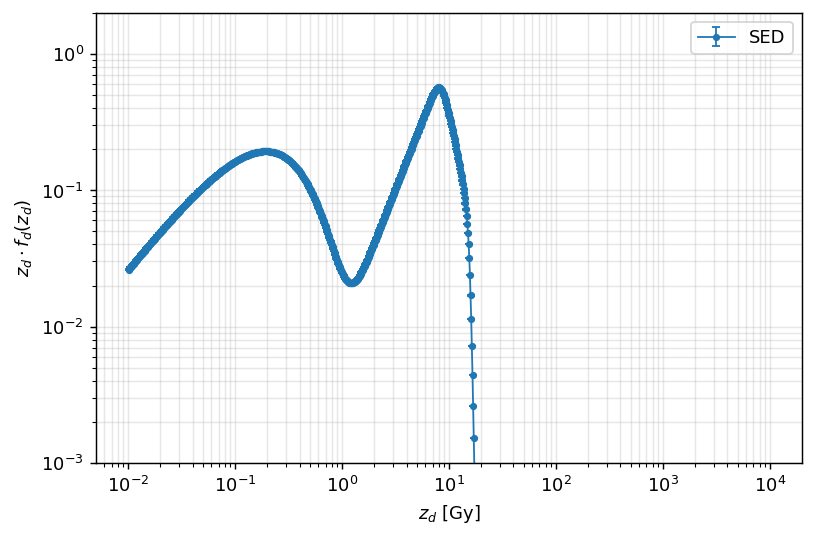

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

#path from drive, file to be read
FNAME = '/content/drive/MyDrive/da_plottare_1.txt'
                                         #prototype of Fig.5.4
x, y, yerr = [], [], []
with open(FNAME) as f:
    for line in f:
        if not line.strip():
            continue
        low = line.lower()
        if low.startswith(('p:','#','x:','y:','h:','title','file','mesh','axis','sed')):
            continue
        vals = line.split()
        if len(vals) >= 3:
            a, b, v = map(float, vals[:3])
            e = float(vals[3]) if len(vals) > 3 else 0.0
            x.append(0.5*(a+b))   # half bin
            y.append(v)
            yerr.append(v*e)


fig, ax = plt.subplots(figsize=(7,4.5), dpi=130)
ax.errorbar(x, y, yerr=yerr, fmt='o-', ms=3, lw=1, capsize=2, label='SED')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.show()



abbiamo visto come la zd finale sia differente rispetto alla figura di Sato, possiamo imputare ciò ad un diverso paramwtro di cdiam, oppure al fatto che non è specificato se la singola rappresentazione della curva verde sia la somma pesata di più simulazioni con differente cdiam, da 0,1 a 0,3. pertanto in seguito verrà rappresentata la singola curva come somma pesata di 5 simulazioni con cdiam di 1.2, 1.5, 2, 2.5, 3.

There is a difference with the final zd value with respect to Sato's paper figure: it's not specified if the nitrogen component is the summation of different cdiam simulation, so hereafter is shown the sum of 5 simulations: cdiam of 1.2, 1.5, 2, 2.5, 3.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


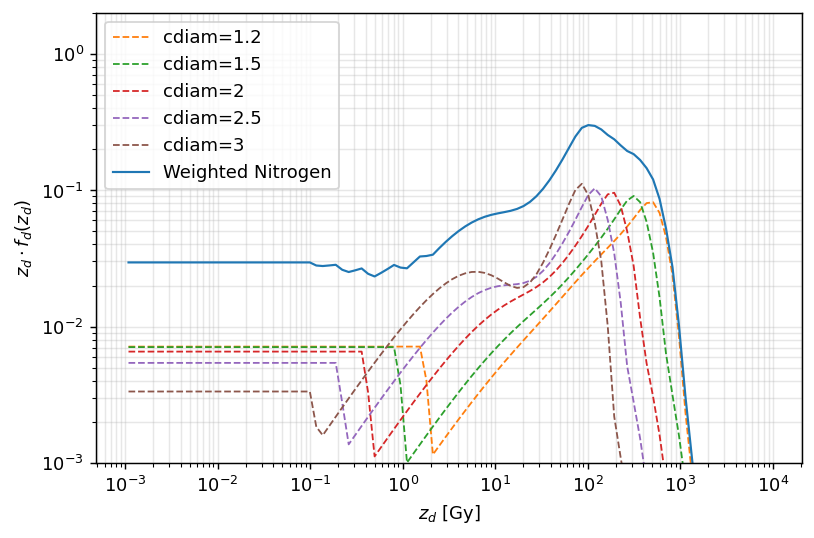

In [ ]:
import re, numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
                                        #Fig. 5.5
FILES = [
    '/content/drive/MyDrive/cdiam1_2.txt',
    '/content/drive/MyDrive/cdiam1_5.txt',
    '/content/drive/MyDrive/cdiam2.txt',
    '/content/drive/MyDrive/cdiam2_5.txt',
    '/content/drive/MyDrive/cdiam3.txt',
]
WEIGHTS = [0.20, 0.20, 0.20, 0.20, 0.20]
NORMALIZE_WEIGHTS = True

LABELS = ['cdiam=1.2','cdiam=1.5','cdiam=2','cdiam=2.5','cdiam=3']

# Strong Parser
_num = re.compile(r'^[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[EeDd][+-]?\d+)?$')
def _is_num(tok: str) -> bool:
    return bool(_num.match(tok))

def parse_sed(fname):
    xs, ys, yerrs = [], [], []
    with open(fname) as f:
        for raw in f:
            s = raw.strip()
            if not s:
                continue
            # remove inline comments
            s = s.split('#', 1)[0].strip()
            if not s:
                continue
            low = s.lower()
            if low.startswith(('p:', 'x:', 'y:', 'h:', 'title', 'file', 'mesh', 'axis', 'sed', 'no.')):
                continue
            toks = s.replace('D','E').replace('d','E').split()
            if len(toks) < 3 or not (_is_num(toks[0]) and _is_num(toks[1]) and _is_num(toks[2])):
                continue
            a = float(toks[0]); b = float(toks[1]); v = float(toks[2])
            e = float(toks[3]) if len(toks) > 3 and _is_num(toks[3]) else 0.0
            xs.append(0.5*(a+b))
            ys.append(v)
            yerrs.append(abs(v)*abs(e))
    return np.array(xs), np.array(ys), np.array(yerrs)

def assert_same_bins(ref_x, other_x, tol=1e-12):
    if len(ref_x) != len(other_x):
        return False
    return np.all(np.abs(ref_x - other_x) <= tol)

#file reading
parsed = [parse_sed(fp) for fp in FILES]

# Sanity check
if any(len(x)==0 for x,_,_ in parsed):
    raise ValueError("Uno dei file non ha prodotto dati numerici (forse solo header?).")

if len(WEIGHTS) != len(FILES):
    raise ValueError(f"Lunghezze diverse: FILES={len(FILES)}, WEIGHTS={len(WEIGHTS)}")

if NORMALIZE_WEIGHTS:
    s = float(sum(WEIGHTS))
    if s == 0.0:
        raise ValueError("Somma pesi = 0.")
    WEIGHTS = [w/s for w in WEIGHTS]

#  Allineamento grids
x_ref = parsed[0][0]
aligned = []
for (x_i, y_i, e_i) in parsed:
    if assert_same_bins(x_ref, x_i):
        aligned.append((x_ref, y_i, e_i))
    else:
        # Interpola su x_ref (assumo y ed errori definiti su x_i ordinato)
        order = np.argsort(x_i)
        x_sorted = x_i[order]; y_sorted = y_i[order]; e_sorted = e_i[order]
        # limiti: extrapolate con 0 fuori dal range
        y_interp = np.interp(x_ref, x_sorted, y_sorted, left=0.0, right=0.0)
        e_interp = np.interp(x_ref, x_sorted, e_sorted, left=0.0, right=0.0)
        aligned.append((x_ref, y_interp, e_interp))

# weighted sum + errori in quadratura
x = x_ref.copy()
y_sum = np.zeros_like(x)
e_var = np.zeros_like(x)

for w, (_, y_i, e_i) in zip(WEIGHTS, aligned):
    y_sum += w * y_i
    e_var += (w * e_i)**2

e_sum = np.sqrt(e_var)

# Plot
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=130)

ax.errorbar(x, y_sum, fmt='-', ms=3, lw=1.2, capsize=2, label='Weighted Nitrogen')

for i, (w, (xi, yi, _)) in enumerate(zip(WEIGHTS, aligned)):
    lab = LABELS[i] if i < len(LABELS) else f'contributo {i+1}'
    ax.plot(xi, w*yi, '--', lw=1, label=f'{lab} ')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


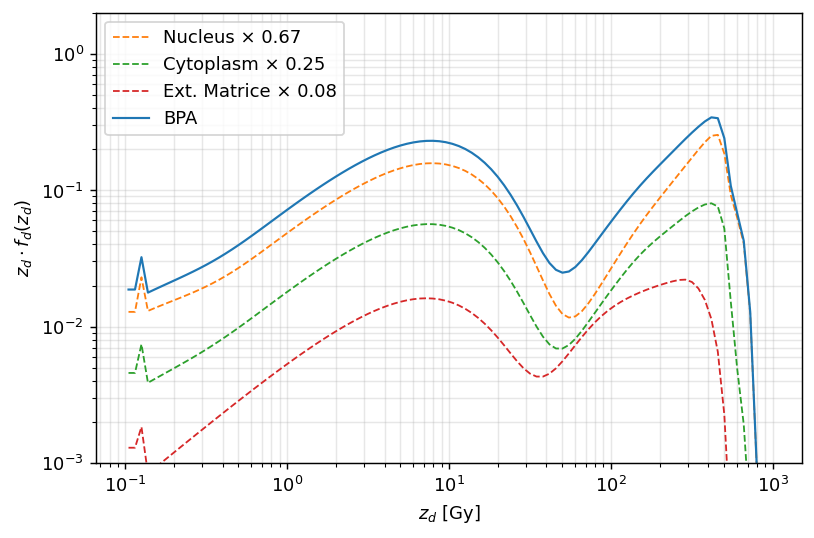

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

                                         #right side of Fig. 5.6
F1 = '/content/drive/MyDrive/zd_B_nuc.txt'
F2 = '/content/drive/MyDrive/zd_B_cit.txt'
F3 = '/content/drive/MyDrive/zd_B_ext.txt'

# contributions' weights
w1, w2, w3 = 0.67, 0.25, 0.08
# Se vuoi normalizzare automaticamente i pesi (somma=1), metti True
NORMALIZE_WEIGHTS = True

# Parser per un file in formato SED "a b v [err_frac]"
# ignora righe vuote e intestazioni note
def parse_sed(fname):
    xs, ys, yerrs = [], [], []
    with open(fname) as f:
        for line in f:
            if not line.strip():
                continue
            low = line.lower()
            if low.startswith(('p:','#','x:','y:','h:','title','file','mesh','axis','sed')):
                continue
            vals = line.split()
            if len(vals) >= 3:
                a, b, v = map(float, vals[:3])
                e = float(vals[3]) if len(vals) > 3 else 0.0  # relative errore
                xs.append(0.5*(a+b))      # half bin
                ys.append(v)
                yerrs.append(v*e)         # absolut error
    return xs, ys, yerrs


x1, y1, e1 = parse_sed(F1)
x2, y2, e2 = parse_sed(F2)
x3, y3, e3 = parse_sed(F3)

# Verifica coerenza bin (stessa lunghezza + stessi centri)
def assert_same_bins(xa, xb, tol=1e-12):
    if len(xa) != len(xb):
        raise ValueError("I file hanno un numero di bin diverso.")
    for i, (a, b) in enumerate(zip(xa, xb)):
        if abs(a - b) > tol:
            raise ValueError(f"I centri bin non coincidono (idx {i}: {a} vs {b}).")

assert_same_bins(x1, x2)
assert_same_bins(x1, x3)

# weight nomalization
if NORMALIZE_WEIGHTS:
    s = (w1 + w2 + w3)
    if s == 0:
        raise ValueError("La somma dei pesi è zero: scegli pesi validi.")
    w1, w2, w3 = w1/s, w2/s, w3/s

# Somma pesata e barre d'errore combinate (in quadratura)
x = x1[:]  # half bin
y_sum = []
e_sum = []
for i in range(len(x)):
    yi = w1*y1[i] + w2*y2[i] + w3*y3[i]
    # errori indipendenti → somma in quadratura dei contributi pesati
    ei = ( (w1*e1[i])**2 + (w2*e2[i])**2 + (w3*e3[i])**2 )**0.5
    y_sum.append(yi)
    e_sum.append(ei)

#  Plot
fig, ax = plt.subplots(figsize=(7,4.5), dpi=130)

# weighted sum curve
ax.errorbar(x, y_sum, fmt='-', ms=3, lw=1.2, capsize=2, label='BPA')

# dashed lines: single contributions
ax.plot(x, [w1*yy for yy in y1], '--', lw=1, label=f'Nucleus × {w1:.3g}')
ax.plot(x, [w2*yy for yy in y2], '--', lw=1, label=f'Cytoplasm × {w2:.3g}')
ax.plot(x, [w3*yy for yy in y3], '--', lw=1, label=f'Ext. Matrice × {w3:.3g}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.show()


.







mostro ora i singoli contributo delle componenti del Boro







.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


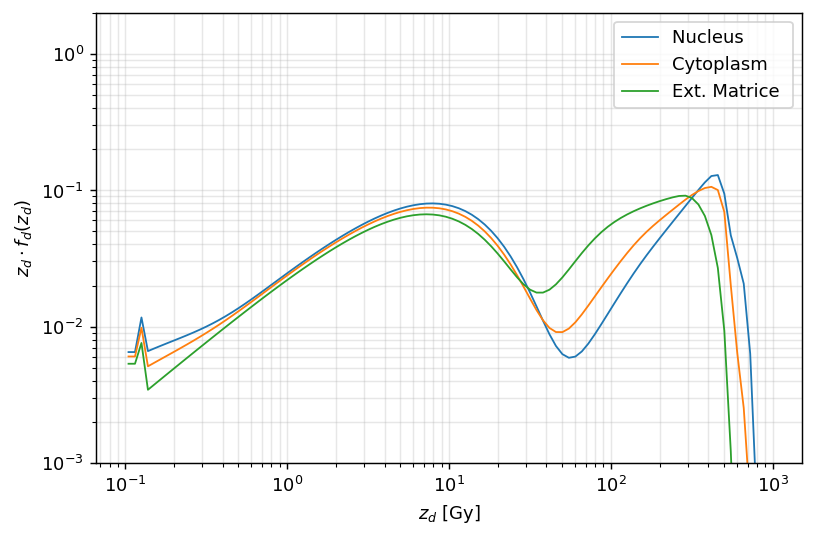

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
                                        #left side of Fig. 5.6
F1 = '/content/drive/MyDrive/zd_B_nuc.txt'
F2 = '/content/drive/MyDrive/zd_B_cit.txt'
F3 = '/content/drive/MyDrive/zd_B_ext.txt'

# contributions' weights
w1, w2, w3 = 0.34, 0.33, 0.33
NORMALIZE_WEIGHTS = True

# Parser for a SED file "a b v [err_frac]"
def parse_sed(fname):
    xs, ys, yerrs = [], [], []
    with open(fname) as f:
        for line in f:
            if not line.strip():
                continue
            low = line.lower()
            if low.startswith(('p:','#','x:','y:','h:','title','file','mesh','axis','sed')):
                continue
            vals = line.split()
            if len(vals) >= 3:
                a, b, v = map(float, vals[:3])
                e = float(vals[3]) if len(vals) > 3 else 0.0
                xs.append(0.5*(a+b))
                ys.append(v)
                yerrs.append(v*e)
    return xs, ys, yerrs

# read the 3 files
x1, y1, e1 = parse_sed(F1)
x2, y2, e2 = parse_sed(F2)
x3, y3, e3 = parse_sed(F3)

# weight normalization
if NORMALIZE_WEIGHTS:
    s = (w1 + w2 + w3)
    w1, w2, w3 = w1/s, w2/s, w3/s

# Plot
fig, ax = plt.subplots(figsize=(7,4.5), dpi=130)

# only single contributions
ax.plot(x1, [w1*yy for yy in y1], '-', lw=1, label=f'Nucleus ')
ax.plot(x2, [w2*yy for yy in y2], '-', lw=1, label=f'Cytoplasm ')
ax.plot(x3, [w3*yy for yy in y3], '-', lw=1, label=f'Ext. Matrice ')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


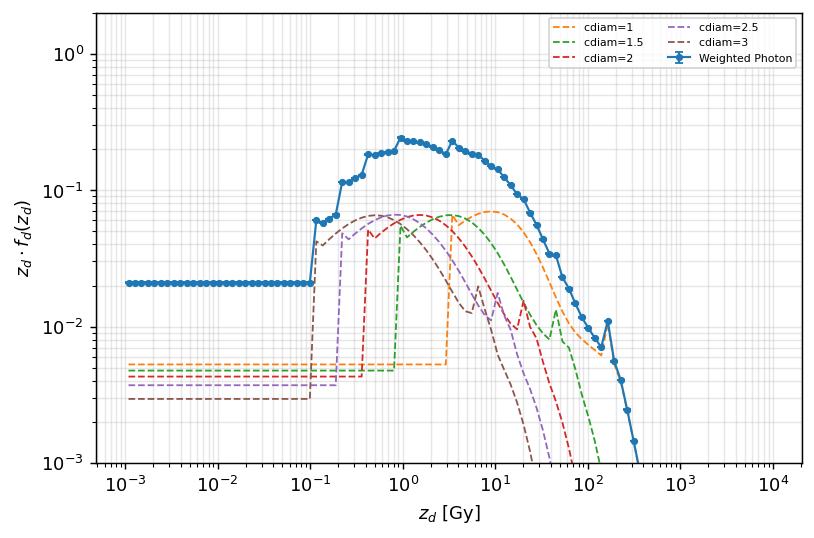

In [ ]:
import re, numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
                                      #left side of Fig. 5.4
FILES = [
    '/content/drive/MyDrive/electron10.txt',
    '/content/drive/MyDrive/electron15.txt',
    '/content/drive/MyDrive/electron20.txt',
    '/content/drive/MyDrive/electron25.txt',
    '/content/drive/MyDrive/electron30.txt',
]
WEIGHTS = [0.20, 0.20, 0.20, 0.20, 0.20]
NORMALIZE_WEIGHTS = True

LABELS = ['cdiam=1','cdiam=1.5','cdiam=2','cdiam=2.5','cdiam=3']

# Strong Parser
_num = re.compile(r'^[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[EeDd][+-]?\d+)?$')
def _is_num(tok: str) -> bool:
    return bool(_num.match(tok))

def parse_sed(fname):
    xs, ys, yerrs = [], [], []
    with open(fname) as f:
        for raw in f:
            s = raw.strip()
            if not s:
                continue
            # remove inline comments
            s = s.split('#', 1)[0].strip()
            if not s:
                continue
            low = s.lower()
            if low.startswith(('p:', 'x:', 'y:', 'h:', 'title', 'file', 'mesh', 'axis', 'sed', 'no.')):
                continue
            toks = s.replace('D','E').replace('d','E').split()
            if len(toks) < 3 or not (_is_num(toks[0]) and _is_num(toks[1]) and _is_num(toks[2])):
                continue
            a = float(toks[0]); b = float(toks[1]); v = float(toks[2])
            e = float(toks[3]) if len(toks) > 3 and _is_num(toks[3]) else 0.0
            xs.append(0.5*(a+b))                 # half bin
            ys.append(v)
            yerrs.append(abs(v)*abs(e))          # absolut error
    return np.array(xs), np.array(ys), np.array(yerrs)

def assert_same_bins(ref_x, other_x, tol=1e-12):
    if len(ref_x) != len(other_x):
        return False
    return np.all(np.abs(ref_x - other_x) <= tol)

#file reading
parsed = [parse_sed(fp) for fp in FILES]

# Sanity check
if any(len(x)==0 for x,_,_ in parsed):
    raise ValueError("Uno dei file non ha prodotto dati numerici (forse solo header?).")

if len(WEIGHTS) != len(FILES):
    raise ValueError(f"Lunghezze diverse: FILES={len(FILES)}, WEIGHTS={len(WEIGHTS)}")

if NORMALIZE_WEIGHTS:
    s = float(sum(WEIGHTS))
    if s == 0.0:
        raise ValueError("Somma pesi = 0.")
    WEIGHTS = [w/s for w in WEIGHTS]

#  Allineamento grids
x_ref = parsed[0][0]
aligned = []
for (x_i, y_i, e_i) in parsed:
    if assert_same_bins(x_ref, x_i):
        aligned.append((x_ref, y_i, e_i))
    else:
        # Interpola su x_ref (assumo y ed errori definiti su x_i ordinato)
        order = np.argsort(x_i)
        x_sorted = x_i[order]; y_sorted = y_i[order]; e_sorted = e_i[order]
        # limiti: extrapolate con 0 fuori dal range
        y_interp = np.interp(x_ref, x_sorted, y_sorted, left=0.0, right=0.0)
        e_interp = np.interp(x_ref, x_sorted, e_sorted, left=0.0, right=0.0)
        aligned.append((x_ref, y_interp, e_interp))

# weighted sum + errori in quadratura
x = x_ref.copy()
y_sum = np.zeros_like(x)
e_var = np.zeros_like(x)

for w, (_, y_i, e_i) in zip(WEIGHTS, aligned):
    y_sum += w * y_i
    e_var += (w * e_i)**2

e_sum = np.sqrt(e_var)

# Plot
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=130)

ax.errorbar(x, y_sum, yerr=e_sum, fmt='o-', ms=3, lw=1.2, capsize=2, label='Weighted Photon')

for i, (w, (xi, yi, _)) in enumerate(zip(WEIGHTS, aligned)):
    lab = LABELS[i] if i < len(LABELS) else f'contributo {i+1}'
    ax.plot(xi, w*yi, '--', lw=1, label=f'{lab} ')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend(ncol=2, fontsize=6)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


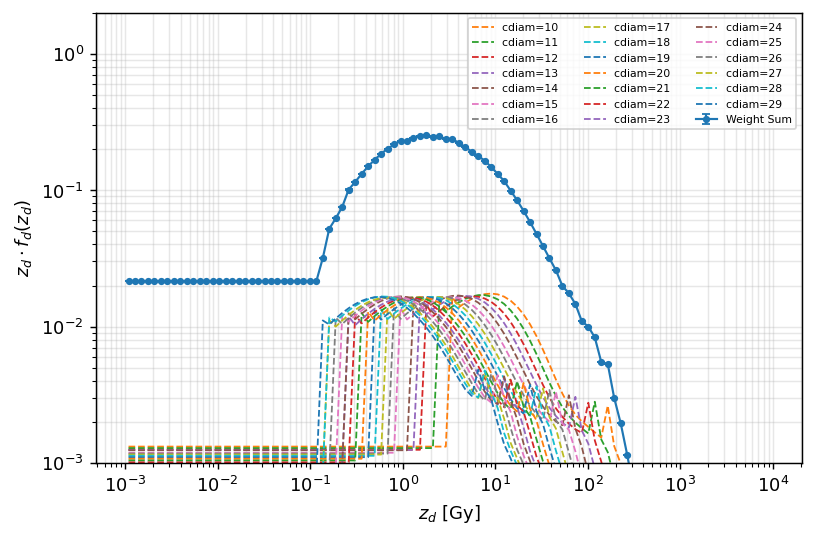

In [ ]:
import re, numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
                                   #right side of Fig. 5.4
#FILES
FILES = [f'/content/drive/MyDrive/electron{i}.txt' for i in range(10, 30)]

#weights
WEIGHTS = [1.0]*20
NORMALIZE_WEIGHTS = True

#smart way for labels
LABELS = [f'cdiam={i}' for i in range(10, 30)]

#Parser
_num = re.compile(r'^[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[EeDd][+-]?\d+)?$')
def _is_num(tok: str) -> bool:
    return bool(_num.match(tok))

def parse_sed(fname):
    xs, ys, yerrs = [], [], []
    with open(fname) as f:
        for raw in f:
            s = raw.strip()
            if not s: continue
            s = s.split('#', 1)[0].strip()
            if not s: continue
            low = s.lower()
            if low.startswith(('p:', 'x:', 'y:', 'h:', 'title', 'file', 'mesh', 'axis', 'sed', 'no.')):
                continue
            toks = s.replace('D','E').replace('d','E').split()
            if len(toks) < 3 or not (_is_num(toks[0]) and _is_num(toks[1]) and _is_num(toks[2])):
                continue
            a = float(toks[0]); b = float(toks[1]); v = float(toks[2])
            e = float(toks[3]) if len(toks) > 3 and _is_num(toks[3]) else 0.0
            xs.append(0.5*(a+b))
            ys.append(v)
            yerrs.append(abs(v)*abs(e))
    return np.array(xs), np.array(ys), np.array(yerrs)

def assert_same_bins(ref_x, other_x, tol=1e-12):
    if len(ref_x) != len(other_x):
        return False
    return np.all(np.abs(ref_x - other_x) <= tol)

# file reading
parsed = [parse_sed(fp) for fp in FILES]

if any(len(x)==0 for x,_,_ in parsed):
    raise ValueError("Uno dei file non ha prodotto dati numerici (forse solo header?).")

if len(WEIGHTS) != len(FILES):
    raise ValueError(f"Lunghezze diverse: FILES={len(FILES)}, WEIGHTS={len(WEIGHTS)}")

if NORMALIZE_WEIGHTS:
    s = float(sum(WEIGHTS))
    if s == 0.0:
        raise ValueError("Somma pesi = 0.")
    WEIGHTS = [w/s for w in WEIGHTS]

# Allineamento grids
x_ref = parsed[0][0]
aligned = []
for (x_i, y_i, e_i) in parsed:
    if assert_same_bins(x_ref, x_i):
        aligned.append((x_ref, y_i, e_i))
    else:
        order = np.argsort(x_i)
        x_sorted = x_i[order]; y_sorted = y_i[order]; e_sorted = e_i[order]
        y_interp = np.interp(x_ref, x_sorted, y_sorted, left=0.0, right=0.0)
        e_interp = np.interp(x_ref, x_sorted, e_sorted, left=0.0, right=0.0)
        aligned.append((x_ref, y_interp, e_interp))

# weighted sum + errori in quadratura
x = x_ref.copy()
y_sum = np.zeros_like(x)
e_var = np.zeros_like(x)

for w, (_, y_i, e_i) in zip(WEIGHTS, aligned):
    y_sum += w * y_i
    e_var += (w * e_i)**2

e_sum = np.sqrt(e_var)

# Plot
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=130)

ax.errorbar(x, y_sum, yerr=e_sum, fmt='o-', ms=3, lw=1.2, capsize=2, label='Weight Sum')

for i, (w, (xi, yi, _)) in enumerate(zip(WEIGHTS, aligned)):
    lab = LABELS[i] if i < len(LABELS) else f'contributo {i+1}'
    ax.plot(xi, w*yi, '--', lw=1, label=f'{lab} ')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend(ncol=3, fontsize=6)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


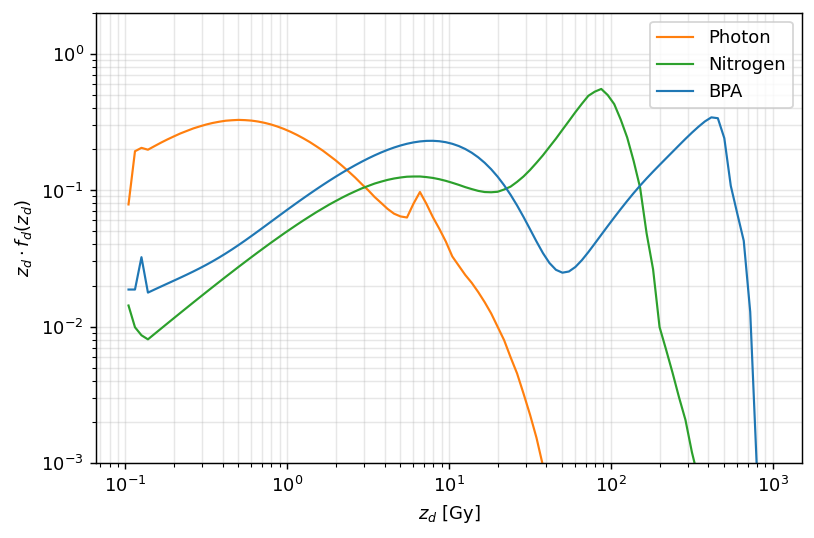

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
                                     #Fig. 5.7
drive.mount('/content/drive')

F_BNUC       = '/content/drive/MyDrive/zd_B_nuc.txt'
F_BCIT       = '/content/drive/MyDrive/zd_B_cit.txt'
F_BEXT       = '/content/drive/MyDrive/zd_B_ext.txt'
F_ELECTRON30 = '/content/drive/MyDrive/electron30.txt'
F_CDIAM3     = '/content/drive/MyDrive/cdiam3.txt'

#weight BPA
w1, w2, w3 = 0.67, 0.25, 0.08
NORMALIZE_WEIGHTS = True

#Parser robusto SED: righe "a b v [err_frac]"
_num = re.compile(r'^[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[EeDd][+-]?\d+)?$')
def _is_num(tok: str) -> bool:
    return bool(_num.match(tok))

def parse_sed(fname):
    xs, ys, yerrs = [], [], []
    with open(fname) as f:
        for raw in f:
            s = raw.strip()
            if not s:
                continue
            s = s.split('#', 1)[0].strip()
            s = s.replace("'", "").replace('"', "")
            if not s:
                continue
            s = s.replace('D', 'E').replace('d', 'E')
            toks = s.split()
            if len(toks) < 3 or not (_is_num(toks[0]) and _is_num(toks[1]) and _is_num(toks[2])):
                continue
            a = float(toks[0]); b = float(toks[1]); v = float(toks[2])
            e = float(toks[3]) if len(toks) > 3 and _is_num(toks[3]) else 0.0
            xs.append(0.5*(a+b))               # half bin
            ys.append(v)
            yerrs.append(abs(v)*abs(e))        # absolut error
    return np.array(xs), np.array(ys), np.array(yerrs)

def assert_same_bins(xa, xb, tol=1e-12):
    if len(xa) != len(xb):
        raise ValueError("Numero di bin diverso tra i file.")
    if not np.all(np.abs(np.array(xa) - np.array(xb)) <= tol):
        raise ValueError("I centri dei bin non coincidono.")

def align_to(x_src, y_src, e_src, x_ref):
    """Interpola (y,e) definiti su x_src -> x_ref. Fuori range: 0."""
    order = np.argsort(x_src)
    xs = x_src[order]; ys = y_src[order]; es = e_src[order]
    y_new = np.interp(x_ref, xs, ys, left=0.0, right=0.0)
    e_new = np.interp(x_ref, xs, es, left=0.0, right=0.0)
    return y_new, e_new

#file reading
x1, y1, e1 = parse_sed(F_BNUC)
x2, y2, e2 = parse_sed(F_BCIT)
x3, y3, e3 = parse_sed(F_BEXT)
x_el, y_el, e_el = parse_sed(F_ELECTRON30)
x_cd, y_cd, e_cd = parse_sed(F_CDIAM3)

#Coerenza bin per BPA
assert_same_bins(x1, x2)
assert_same_bins(x1, x3)

#weight normalization
if NORMALIZE_WEIGHTS:
    s = w1 + w2 + w3
    if s == 0:
        raise ValueError("Somma pesi nulla.")
    w1, w2, w3 = w1/s, w2/s, w3/s

#weighted sum BPA + errori in quadratura
x_ref = x1.copy()
y_bpa = w1*y1 + w2*y2 + w3*y3
e_bpa = np.sqrt((w1*e1)**2 + (w2*e2)**2 + (w3*e3)**2)

#Allinea electron30 e cdiam3 ai bin di BPA (x_ref)
y_el_al, e_el_al = align_to(x_el, y_el, e_el, x_ref)
y_cd_al, e_cd_al = align_to(x_cd, y_cd, e_cd, x_ref)

#Plot: BPA + electron30 + cdiam3
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=130)

# BPA with error bars
ax.errorbar(x_ref, y_bpa, fmt='-', ms=3, lw=1.2, capsize=2, label='BPA')

# electron30 e cdiam3 allineati su x_ref
ax.plot(x_ref, y_el_al, '-', lw=1.2, label='Photon')
ax.plot(x_ref, y_cd_al, '-', lw=1.2, label='Nitrogen')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-3, 2))
ax.set_xlabel(r"$z_d$ [Gy]")
ax.set_ylabel(r"$z_d \cdot f_d(z_d)$")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.show()

questo codice sottostante corregge per la massa del nucleo: va a modificare ognuno dei 5 file che raggiunge nel drive e li risalva lì modificandone il nome

In [ ]:
import os
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

rho = 1.0e3      # [kg/m^3]
V   = 523e-19    # [m^3]     (sphere r=5 µm -> 5.23e-19 m^3)
m_kg = rho * V   # massa [kg]
print(f"Massa nucleo: {m_kg:.3e} kg")

BASE = "/content/drive/MyDrive"
inputs = [
    "zn_fz1_from_cit.txt",
    "zn_fz1_from_nuc.txt",
    "zn_fz1_from_ext.txt",
    "zn_fz1_from_electron.txt",
    "zn_fz1_from_nitro.txt",
]

def out_name(fname):
    # remove "_from_" and keep  zn_fz1_ in the name
    return fname.replace("_from_", "_normalized_")

# LOOP: MASS CORRECTION + saving
for fname in inputs:
    inpath = os.path.join(BASE, fname)
    if not os.path.exists(inpath):
        print(f"⚠️  Non trovato: {inpath}")
        continue

    # load data (2 columns: zn[Gy], pdf)
    arr = np.loadtxt(inpath, comments="#")
    if arr.ndim == 1:  #single line -> not valid
        print(f"⚠️  Formato inatteso in {inpath} (una sola riga).")
        continue
    zn_old = arr[:, 0].astype(float)
    pdf_old = arr[:, 1].astype(float)


    # variable change for mass correction:
    # z_new = z_old / m ;  pdf_new = pdf_old * m
    zn_new  = zn_old / m_kg
    pdf_new = pdf_old * m_kg
    normalization = np.sum(pdf_new)
    pdf_new = pdf_new / normalization


    # Save output
    outname = out_name(fname)
    outpath = os.path.join(BASE, outname)
    np.savetxt(outpath, np.column_stack([zn_new, pdf_new]),
               header="zn[Gy]   pdf (mass-corrected)", fmt="%.6e")
    print(f"✔ Salvato {outpath}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Massa nucleo: 5.230e-14 kg
✔ Salvato /content/drive/MyDrive/zn_fz1_normalized_cit.txt
✔ Salvato /content/drive/MyDrive/zn_fz1_normalized_nuc.txt
✔ Salvato /content/drive/MyDrive/zn_fz1_normalized_ext.txt
✔ Salvato /content/drive/MyDrive/zn_fz1_normalized_electron.txt
✔ Salvato /content/drive/MyDrive/zn_fz1_normalized_nitro.txt


In [ ]:
import os
import pandas as pd

#  Measured data to be converted into csv file
# columns: Dose[Gy], ErrDose[Gy], SF[%], ErrSF[%]
rows = [
    (0.0,  0.00, 100.0, 10.0),
    (0.58,  0.06,  5.5,  0.55),
    (2.33,  0.02,  0.7,  0.7),


]

df = pd.DataFrame(rows, columns=["D","dD","Sexp","dS"])

#save the csv in the drive
out_path = "/content/drive/MyDrive/Phits/sf_data_bnct.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df.to_csv(out_path, index=False)
print("Creato CSV sperimentale in:", out_path)
print(df)


Creato CSV sperimentale in: /content/drive/MyDrive/Phits/sf_data_bnct.csv
      D    dD   Sexp     dS
0  0.00  0.00  100.0  10.00
1  0.58  0.06    5.5   0.55
2  2.33  0.02    0.7   0.70


In [ ]:
#  PHITS sed Converter (columns: sed-lwr sed-upr y=z*f(z) err)
# -> build f(z) per event on z_mid normalize and then save as 2-columns.

import numpy as np
from google.colab import drive
drive.mount('/content/drive')
def load_phits_sed_zfz(path):
    """
    Legge un file PHITS 'sed' dove la 3a colonna è y = z*f(z).
    Ritorna:
      z_mid  : centri geometrici dei bin (Gy)
      f_mid  : stima di f(z) al centro del bin (normalizzata, 1D pdf)
      info   : dizionario con controlli (area, mean_z, nbins)
    """

    rows = []
    with open(path, "r") as fh:
        for line in fh:
            parts = line.strip().split()
            if len(parts) < 4:
                continue
            try:
                zl = float(parts[0]); zu = float(parts[1])
                y  = float(parts[2])  # y = z*f(z)
                _e = float(parts[3])  # error
            except ValueError:
                continue
            # scarta righe con z=0 o y negativi
            if zl <= 0 or zu <= 0:
                continue
            rows.append((zl, zu, y))
    if not rows:
        raise ValueError("Nessun dato numerico trovato nel file PHITS sed.")

    data = np.array(rows, dtype=float)
    z_low  = data[:,0]
    z_high = data[:,1]
    y_zfz  = data[:,2]

    # bin log-space
    z_mid = np.sqrt(z_low * z_high)
    dz    = z_high - z_low

    # f(z_mid) ~ y / z_mid
    f_mid = np.zeros_like(z_mid)
    mask  = z_mid > 0
    f_mid[mask] = y_zfz[mask] / z_mid[mask]
    f_mid = np.clip(f_mid, 0.0, None)

    # normalization: ∫ f(z) dz = 1
    area = np.sum(f_mid * dz)
    if area <= 0 or not np.isfinite(area):
        raise ValueError("Impossibile normalizzare: area <= 0.")
    f_mid /= area

    # check
    mean_z = float(np.sum(z_mid * f_mid * dz))
    info = dict(area=float(np.sum(f_mid*dz)), mean_z=mean_z, nbins=len(z_mid))
    return z_mid, f_mid, info

def save_two_column(path_out, x, y):
    """ Salva due colonne con header minimale. """
    hdr = "# zn [Gy]\tfn1(zn) [1/Gy]\n"
    arr = np.column_stack([x, y])
    np.savetxt(path_out, arr, header=hdr, comments="", fmt="%.8e")

if __name__ == "__main__":
    in_path  = "/content/drive/MyDrive/Phits/zd_BN.txt"   # to be used for all contributions
    out_path = "/content/drive/MyDrive/Phits/fd1_BN_zd.txt"

    zn, fn1, info = load_phits_sed_zfz(in_path)
    print(f"Caricati {info['nbins']} bin. Check normalizzazione ∫f dz ≈ {info['area']:.6f} (atteso 1.0)")
    print(f"Frequency mean <z> ricostruita ≈ {info['mean_z']:.6g} Gy")
    save_two_column(out_path, zn, fn1)
    print(f"Salvato 2-colonne in: {out_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Caricati 100 bin. Check normalizzazione ∫f dz ≈ 1.000000 (atteso 1.0)
Frequency mean <z> ricostruita ≈ 610.227 Gy
Salvato 2-colonne in: /content/drive/MyDrive/Phits/fd1_BN_zd.txt


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from google.colab import drive
drive.mount('/content/drive')
                                        #Fig. 5.9
# ===============================
# Photon parameters fixed
# ===============================
KAPPA          = 1.10
GLOBAL_T_HOURS = 0.03
ALPHA_FIX      = 0.218088     # Gy^-1
BETA_FIX       = 0.000182434  # Gy^-2

# dataset CSV: here are saved as tables the measured data of Sj:
# doses, survivals, errors for the 3 different irradiations
SF_DATA_PATH        = "/content/drive/MyDrive/Phits/sf_data_bnct.csv"
SF_DATA_PATH_GAMMA  = "/content/drive/MyDrive/Phits/sf_data.csv"
SF_DATA_PATH_NEUTRON= "/content/drive/MyDrive/Phits/sf_data_n.csv"

# calculated weight for neutron curve
W_PHOTON_2C = 0.6047
W_NITRO_2C  = 0.3953

# imported fundamentals values from previous codes
components_fixed = [
    {"name": "photons",             "zdD": 90.1436,   "znF": 1.48488,   "w": 0.098},
    {"name": "nitrogen",            "zdD": 658.616,   "znF": 45.4511,   "w": 0.064},
    {"name": "boron_nucleus",       "zdD": 2985.79,   "znF": 117.256,   "w": 0.562},
    {"name": "boron_cytoplasm",     "zdD": 2600.72,   "znF": 107.123,   "w": 0.210},
    {"name": "boron_extracellular", "zdD": 1980.14,   "znF": 89.4885,   "w": 0.067},
]

# ===============================
#  Basis Functions
# ===============================
def load_sf_csv(path, global_T_hours=None):
    if not os.path.exists(path):
        return None, None, None, None, None
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    def colget(name, required=True):
        key = name.lower()
        if required and key not in cols:
            raise ValueError(f"Manca colonna {name} in {path}")
        return df[cols[key]].to_numpy(float) if key in cols else None

    D    = colget("D")
    dD   = colget("dD")
    Sexp = colget("Sexp")
    dS   = colget("dS")
    Tvec = colget("T_hours", False)
    if np.nanmax(Sexp) > 1.5: Sexp /= 100.0
    if np.nanmax(dS)   > 1.5: dS   /= 100.0
    if Tvec is None:
        Tvec = np.full_like(D, global_T_hours if global_T_hours else np.nan)
    return D, dD, Sexp, dS, Tvec

def G_bimodal(T_hours, t0_fast=91.42, t0_slow=1238.0,    # improvement with respect of Sato's paper, now
              p_fast=0.77, p_slow=0.23):                 # G is bi-modal
    if T_hours is None or not np.isfinite(T_hours) or T_hours <= 0:
        return 1.0
    def G_single(T, t0):
        theta = T*60.0
        r = t0/theta
        return 2*r - 2*(r**2)*(1-np.exp(-theta/t0))
    return p_fast*G_single(T_hours, t0_fast) + p_slow*G_single(T_hours, t0_slow)

def get_zdD_by_name(name):
    for c in components_fixed:
        if c["name"] == name:
            return c["zdD"]
    raise KeyError(f"Componente {name} non trovato.")

def S_curve_vec(Dv, zdD, alpha0, beta0, T_hours_vec):
    Gv   = np.vectorize(G_bimodal)(T_hours_vec)
    zbar = KAPPA * Dv
    expo = -(alpha0*zbar + beta0*Gv*zdD*zbar**2)
    return np.exp(np.clip(expo, -700, 0))

def intercept_D(D, S, target=0.1):
    m = (S > 0) & np.isfinite(S)
    if np.sum(m) < 2: return np.nan
    Dm, Sm = D[m], S[m]
    if not (Sm.min() <= target <= Sm.max()): return np.nan
    order = np.argsort(Sm)
    return float(np.interp(np.log(target), np.log(Sm[order]), Dm[order]))

# ===============================
# Overall Plot
# ===============================
def plot_all_curves_with_data(
        sf_csv_bnct=SF_DATA_PATH,
        sf_csv_gamma=SF_DATA_PATH_GAMMA,
        sf_csv_neutron=SF_DATA_PATH_NEUTRON,
        alpha0=ALPHA_FIX, beta0=BETA_FIX,
        global_T_hours=GLOBAL_T_HOURS,
        dplot_max=10.0, nplot=1200):

    # dataset loading
    D_b, dD_b, S_b, dS_b, T_b = load_sf_csv(sf_csv_bnct, global_T_hours)
    D_g, dD_g, S_g, dS_g, T_g = load_sf_csv(sf_csv_gamma, global_T_hours)
    D_n, dD_n, S_n, dS_n, T_n = load_sf_csv(sf_csv_neutron, global_T_hours)

    # grid
    D_plot = np.linspace(0, dplot_max, nplot)
    T_plot = np.full_like(D_plot, global_T_hours)

    # BNCT 5 components
    S_tot_bnct = np.ones_like(D_plot)
    for c in components_fixed:
        S_c = S_curve_vec(D_plot, c["zdD"], alpha0, beta0, T_plot)
        S_tot_bnct *= S_c**c["w"]

    # Photons
    zdD_ph = get_zdD_by_name("photons")
    S_ph = S_curve_vec(D_plot, zdD_ph, alpha0, beta0, T_plot)

    # Nitrogen
    zdD_ni = get_zdD_by_name("nitrogen")
    S_ni = S_curve_vec(D_plot, zdD_ni, alpha0, beta0, T_plot)

    # neutrons curve
    S_mix = np.clip(S_ph**W_PHOTON_2C * S_ni**W_NITRO_2C, 1e-18, 1.0)

    # Boron-only with proper weights
    w_BN, w_BC, w_BE = 0.67, 0.25, 0.08
    zdD_BN = get_zdD_by_name("boron_nucleus")
    zdD_BC = get_zdD_by_name("boron_cytoplasm")
    zdD_BE = get_zdD_by_name("boron_extracellular")
    S_BN = S_curve_vec(D_plot, zdD_BN, alpha0, beta0, T_plot)
    S_BC = S_curve_vec(D_plot, zdD_BC, alpha0, beta0, T_plot)
    S_BE = S_curve_vec(D_plot, zdD_BE, alpha0, beta0, T_plot)
    S_boron = np.clip((S_BN**w_BN)*(S_BC**w_BC)*(S_BE**w_BE), 1e-18, 1.0)

    # --- plot ---
    plt.figure(figsize=(7,4.6))
    plt.semilogy(D_plot, S_tot_bnct, '-',  lw=2.0, label="BNCT")
    plt.semilogy(D_plot, S_ph,        '-', lw=1.5, label="Photons")
    plt.semilogy(D_plot, S_ni,        '--', lw=1.5, label="Nitrogen")
    plt.semilogy(D_plot, S_mix,       '-', lw=2.0, label="Neutrons")
    plt.semilogy(D_plot, S_boron,     '--',  lw=2.0, label="Boron")

    # measured data
    if D_b is not None:
        plt.errorbar(D_b, S_b, yerr=dS_b, fmt='o', color='blue',
                     ecolor='black', capsize=3, label="Measured BNCT")
    if D_g is not None:
        plt.errorbar(D_g, S_g, yerr=dS_g, fmt='o', color='orange',
                     ecolor='black', capsize=3, label="Measured Photons")
    if D_n is not None:
        plt.errorbar(D_n, S_n, yerr=dS_n, fmt='o', color='red',
                     ecolor='black', capsize=3, label="Measured Neutrons")

    plt.xlabel("Dose D [Gy]")
    plt.ylabel("Survival fraction (SF)")
    plt.ylim(1e-3, 1)
    plt.xlim(0, 12)
    plt.legend()
    plt.grid(True, which="both", alpha=0.4)
    plt.tight_layout()
    plt.show()

# ===============================
# Plotting
# ===============================
plot_all_curves_with_data(dplot_max=12.0)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from google.colab import drive
drive.mount('/content/drive')
                                     #Neutron fitted curve + smoother curve
# ===============================
# PATH E CONFIG
# ===============================

PHOTON_FN1_PATH = "/content/drive/MyDrive/Phits/fn1_zn_from_sed.txt"  # z_n, f_n1 (photon)
PHOTON_FD1_PATH = "/content/drive/MyDrive/Phits/fd1_zd_from_sed.txt"  # z_d, f_d1 (photon)


NITRO_FN1_PATH  = "/content/drive/MyDrive/Phits/fn1_nitrogen_zn.txt" # z_n, f_n1 (nitrogen)
NITRO_FD1_PATH  = "/content/drive/MyDrive/Phits/fd1_nitrogen_zd.txt" # z_d, f_d1 (nitrogen)

# measured data, from CSV: D, dD, Sexp, dS
SF_DATA_PATH    = "/content/drive/MyDrive/Phits/sf_data_n.csv"

# weight of contributs, sum has to be 1
W_PHOTON = 0.6047
W_NITRO  = 0.3953

# global parameters
KAPPA          = 1.10       # \bar{z}_n = κ D
GLOBAL_T_HOURS = 0.03       # se il CSV non ha T_hours, uso questo
THETA0_ALPHA0  = 0.29       # Gy^-1 (ini fit)
THETA0_BETA0   = 0.01       # Gy^-2 (ini fit)

# G bi-modale (in min) as formula
T0_FAST_MIN  = 91.42
T0_SLOW_MIN  = 1238.0
P_FAST_PHOTONS, P_SLOW_PHOTONS = 0.77, 0.23  # weights for fast/slow mixture


# ===============================
# IO
# ===============================
def load_two_col_txt(path):
    """Legge txt a due colonne (spazi/tab). Ritorna x, y come float."""
    arr = np.loadtxt(path)
    return arr[:,0].astype(float), arr[:,1].astype(float)

def normalize_pdf(z, f):
    area = np.trapz(f, z)
    return f / max(area, 1e-300)

# ===============================
# Eq.(2) & Eq.(8)
# ===============================
def eq02_zdD(zd, f_d1):
    """
    z_{d,D} = (∫ z_d^2 f_{d,1} dz) / (∫ z_d f_{d,1} dz)
    (f_d1 normalizzata prima)
    """
    f = normalize_pdf(zd, f_d1)
    num = np.trapz((zd**2) * f, zd)
    den = np.trapz(zd * f, zd)
    if den <= 0:
        raise ValueError("Denominatore non positivo in z_{d,D}.")
    return num / den

def eq08_znF(zn, f_n1):
    """z_{n,F} = ∫ z_n f_{n,1}(z_n) dz_n (solo report)."""
    f = normalize_pdf(zn, f_n1)
    return np.trapz(zn * f, zn)

# ===============================
# G(T) bi-modal (θ e t0 in min)
# ===============================
def G_single_from_formula(T_hours, t0_min):
    if T_hours is None or not np.isfinite(T_hours) or T_hours <= 0:
        return 1.0
    theta_min = float(T_hours) * 60.0
    t0 = float(t0_min)
    if theta_min <= 1e-12 or t0 <= 0:
        return 1.0
    r = t0 / theta_min
    G = 2.0 * r - 2.0 * (r**2) * (1.0 - np.exp(-theta_min / t0))
    return float(np.clip(G, 0.0, 1.0))

def G_bimodal(T_hours, p_fast=P_FAST_PHOTONS, p_slow=P_SLOW_PHOTONS):
    """Miscela fast/slow; T dipende dalla consegna dose, non dal canale."""
    if T_hours is None or not np.isfinite(T_hours) or T_hours <= 0:
        return 1.0
    Gf = G_single_from_formula(T_hours, T0_FAST_MIN)
    Gs = G_single_from_formula(T_hours, T0_SLOW_MIN)
    return p_fast * Gf + p_slow * Gs

# ===============================
# Eq.(9) + Eq.(14)
# ===============================
def eq09_SC(alpha0, beta0, G, zdD, z_n):
    """S_C(z_n) = exp[-(α0 z_n + β0 G zdD z_n^2)]."""
    expo = -(alpha0 * z_n + beta0 * G * zdD * (z_n**2))
    return np.exp(np.clip(expo, -700, 0.0))

def S_component_delta(alpha0, beta0, zdD_comp, kappa, D, T_hours=None):
    """S_i(D) per il singolo canale (delta-approx)."""
    zbar = kappa * D
    G = G_bimodal(T_hours) if (T_hours is not None) else 1.0
    return eq09_SC(alpha0, beta0, G, zdD_comp, zbar)

def S_total_weighted(alpha0, beta0,
                     zdD_ph, zdD_nitro,
                     w_photon, w_nitro,
                     kappa, D, Tj):
    """S_tot = S_photons^wγ * S_nitro^wN (pesi relativi)."""
    Sph = S_component_delta(alpha0, beta0, zdD_ph,    kappa, D, Tj)
    Sni = S_component_delta(alpha0, beta0, zdD_nitro, kappa, D, Tj)
    Stot = (Sph**w_photon) * (Sni**w_nitro)
    return float(np.clip(Stot, 1e-16, 1.0))

# ===============================
# Loading measured data
# ===============================
def load_sf_csv(path, global_T_hours=None):
    """
    CSV con colonne:
      D, dD, Sexp, dS, (opz) T_hours
    Restituisce: D, dD, Sexp, dS, T_vec
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV sperimentale non trovato: {path}")
    df = pd.read_csv(path)


    cols = {c.lower(): c for c in df.columns}
    def colget(name, required=True):
        key = name.lower()
        if required and key not in cols:
            raise ValueError(f"Manca la colonna '{name}' nel CSV.")
        return df[cols[key]].to_numpy(float) if key in cols else None

    D    = colget("D",    True)
    dD   = colget("dD",   True)
    Sexp = colget("Sexp", True)
    dS   = colget("dS",   True)
    Tvec = colget("T_hours", False)


    if np.nanmax(Sexp) > 1.5:
        Sexp = Sexp / 100.0
    if np.nanmax(dS) > 1.5:
        dS = dS / 100.0

    if Tvec is None:
        Tvec = np.full_like(D, np.nan)
    if global_T_hours is not None and np.all(~np.isfinite(Tvec)):
        Tvec[:] = float(global_T_hours)

    return D, dD, Sexp, dS, Tvec

# ===============================
# Residuals for the fit
# ===============================
def residuals_two_comp(theta, D, dD, Sexp, dS, T_vec,
                       zdD_ph, zdD_nitro,
                       w_photon, w_nitro,
                       kappa):
    alpha0, beta0 = theta[0], theta[1]
    Smod = np.empty_like(Sexp, float)
    for j, Dj in enumerate(D):
        Tj = T_vec[j] if T_vec is not None else None
        Smod[j] = S_total_weighted(alpha0, beta0,
                                   zdD_ph, zdD_nitro,
                                   w_photon, w_nitro,
                                   kappa, Dj, Tj)

    return (Sexp - np.clip(Smod, 1e-16, 1.0)) / np.maximum(dS, 1e-3)

# ===============================
# principal pipeline
# ===============================
def run_photon_plus_nitrogen(ph_fn1_path, ph_fd1_path,
                             ni_fn1_path, ni_fd1_path,
                             sf_csv_path,
                             w_photon=W_PHOTON, w_nitro=W_NITRO,
                             kappa=KAPPA,
                             theta0_alpha=THETA0_ALPHA0, theta0_beta=THETA0_BETA0,
                             global_T_hours=GLOBAL_T_HOURS):

    # photon loading
    zn_ph, fn1_ph = load_two_col_txt(ph_fn1_path)
    zd_ph, fd1_ph = load_two_col_txt(ph_fd1_path)
    fn1_ph = normalize_pdf(zn_ph, fn1_ph)
    fd1_ph = normalize_pdf(zd_ph, fd1_ph)

    # nitrogen loading
    zn_ni, fn1_ni = load_two_col_txt(ni_fn1_path)
    zd_ni, fd1_ni = load_two_col_txt(ni_fd1_path)
    fn1_ni = normalize_pdf(zn_ni, fn1_ni)
    fd1_ni = normalize_pdf(zd_ni, fd1_ni)

    # microdosimetric quantities
    zdD_ph = eq02_zdD(zd_ph, fd1_ph)
    znF_ph = eq08_znF(zn_ph, fn1_ph)
    zdD_ni = eq02_zdD(zd_ni, fd1_ni)
    znF_ni = eq08_znF(zn_ni, fn1_ni)

    # measured data
    D, dD, Sexp, dS, T_vec = load_sf_csv(sf_csv_path, global_T_hours)

    # fit α0, β0
    theta0 = np.array([theta0_alpha, theta0_beta])
    bounds = ([0.0, 0.0], [np.inf, np.inf])
    res = least_squares(
        residuals_two_comp, theta0,
        args=(D, dD, Sexp, dS, T_vec,
              zdD_ph, zdD_ni,
              w_photon, w_nitro,
              kappa),
        method="trf", bounds=bounds,
        loss="soft_l1", f_scale=0.05, x_scale='jac',
        ftol=1e-10, xtol=1e-10, gtol=1e-10, max_nfev=5000, verbose=0
    )
    alpha0, beta0 = res.x

    # curve construction
    S_ph = np.array([
        S_component_delta(alpha0, beta0, zdD_ph, kappa, Dj,
                          (T_vec[j] if T_vec is not None else None))
        for j, Dj in enumerate(D)
    ])
    S_ni = np.array([
        S_component_delta(alpha0, beta0, zdD_ni, kappa, Dj,
                          (T_vec[j] if T_vec is not None else None))
        for j, Dj in enumerate(D)
    ])
    S_tot = np.clip((S_ph**w_photon) * (S_ni**w_nitro), 1e-16, 1.0)

    # total curve + error bars
    plt.figure(figsize=(6,4))
    plt.errorbar(D, Sexp, yerr=dS*5, xerr=dD,
                 fmt='x', color='red', ecolor='black', capsize=3,
                 label="Measured")
    plt.semilogy(D, S_tot, '-', label="Fit S_Neutrons")
    # show contributes
    plt.semilogy(D, S_ph, '--', alpha=0.7, label=f"S_photons (w={w_photon:.2f})")
    plt.semilogy(D, S_ni,  '--', alpha=0.7, label=f"S_nitrogen (w={w_nitro:.2f})")
    plt.xlabel("Dose D [Gy]")
    plt.ylabel("Survival fraction (SF)")
    plt.grid(True, which="both", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # summary printed
    n, p = len(D), len(res.x)
    chi2 = float(np.sum(res.fun**2)); dof = max(n-p,1); chi2_red = chi2/dof
    print("=== FIT due componenti (fotoni + azoto) ===")
    print(f"alpha0 = {alpha0:.6g} Gy^-1 ; beta0 = {beta0:.6g} Gy^-2")
    print(f"[Photons]  z_d,D = {zdD_ph:.6g} Gy ; z_n,F = {znF_ph:.6g} Gy ; w = {w_photon:.3f}")
    print(f"[Nitrogen] z_d,D = {zdD_ni:.6g} Gy ; z_n,F = {znF_ni:.6g} Gy ; w = {w_nitro:.3f}")
    print(f"chi^2 = {chi2:.3f} ; dof = {dof} ; chi^2_red = {chi2_red:.3f}")

    return dict(alpha0=alpha0, beta0=beta0,
                zdD_ph=zdD_ph, znF_ph=znF_ph,
                zdD_ni=zdD_ni, znF_ni=znF_ni,
                w_photon=w_photon, w_nitro=w_nitro,
                chi2=chi2, dof=dof, chi2_red=chi2_red,
                D=D, dD=dD, Sexp=Sexp, dS=dS, S_tot=S_tot)

# ===============================
# Run +  "SMOOTH"
# ===============================
res = run_photon_plus_nitrogen(
    PHOTON_FN1_PATH, PHOTON_FD1_PATH,
    NITRO_FN1_PATH,  NITRO_FD1_PATH,
    SF_DATA_PATH,
    w_photon=W_PHOTON, w_nitro=W_NITRO,
    kappa=KAPPA,
    theta0_alpha=THETA0_ALPHA0, theta0_beta=THETA0_BETA0,
    global_T_hours=GLOBAL_T_HOURS
)

#fitted parameters
alpha0   = float(res["alpha0"])
beta0    = float(res["beta0"])
zdD_ph   = float(res["zdD_ph"])
zdD_ni   = float(res["zdD_ni"])

D   = np.asarray(res["D"], float)
dD  = np.asarray(res["dD"], float)
Sexp= np.asarray(res["Sexp"], float)
dS  = np.asarray(res["dS"], float)


D_SMOOTH_MAX = max(10.0, 1.2 * float(np.nanmax(D)))
D_plot = np.linspace(0.0, D_SMOOTH_MAX, 1000)

# irradiation time
T_plot = np.full_like(D_plot, float(GLOBAL_T_HOURS), dtype=float)


def S_comp_vec(zdD_comp):
    Gv   = np.vectorize(G_bimodal)(T_plot)
    zbar = KAPPA * D_plot
    expo = -(alpha0 * zbar + beta0 * Gv * zdD_comp * zbar**2)
    return np.exp(np.clip(expo, -700.0, 0.0))

S_ph_plot  = S_comp_vec(zdD_ph)
S_ni_plot  = S_comp_vec(zdD_ni)
S_tot_plot = np.clip((S_ph_plot**W_PHOTON) * (S_ni_plot**W_NITRO), 1e-16, 1.0)

# measured data + smooth curve
plt.figure(figsize=(6,4))
plt.errorbar(D, Sexp, yerr=dS, xerr=dD, fmt='x', color='red',
             ecolor='black', capsize=3, label="Measured")

plt.semilogy(D_plot, S_tot_plot, '-', linewidth=2.0, label="Fit S_Neutrons (smooth)")
plt.semilogy(D_plot, S_ph_plot,  '--', alpha=0.6, label=f"Photons (w={W_PHOTON:.2f})")
plt.semilogy(D_plot, S_ni_plot,  '--', alpha=0.6, label=f"Nitrogen (w={W_NITRO:.2f})")

plt.xlabel("Dose D [Gy]")
plt.ylabel("Survival fraction (SF)")
plt.grid(True, which="both", alpha=0.4)
plt.legend()
plt.tight_layout()

# desired zoom
plt.xlim(0, 10)
plt.ylim(1e-3, 1)  # y range

plt.show()

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from google.colab import drive
drive.mount('/content/drive')
                                 #Fig.5.8 Photon fitted curve

FN1_EXCEL_PATH = "/content/drive/MyDrive/fn1_zn_from_sed.txt"  # z_n, f_n1
FD1_EXCEL_PATH = "/content/drive/MyDrive/fd1_zd_from_sed.txt"  # z_d, f_d1
SF_DATA_PATH   = "/content/drive/MyDrive/sf_data.csv"          # D, Sexp, dS,

KAPPA          = 1.10
GLOBAL_T_HOURS = 0.03

# first try value for the fit
THETA0_ALPHA0  = 0.29     # Gy^-1
THETA0_BETA0   = 0.01     # Gy^-2

# Model
USE_CONV = True                 # True = use convolution FFT
USE_PHOTONS_WEIGHTS = True      # True → photons weights (0.77, 0.23)

# G bi-modal (in min)
T0_FAST_MIN  = 91.42
T0_SLOW_MIN  = 1238.0
P_FAST_PHOTONS, P_SLOW_PHOTONS = 0.77, 0.23
P_FAST_BNCT,   P_SLOW_BNCT     = 0.20, 0.80

# ===============================
# IO
# ===============================
def load_two_col(path):
    # default: separatore bianco → robusto per .txt
    arr = np.loadtxt(path)
    x, y = arr[:,0].astype(float), arr[:,1].astype(float)
    return x, y

# ===============================
# PDF helpers
# ===============================
def _uniformize_pdf(z, f):
    z = np.asarray(z, float); f = np.asarray(f, float)
    zmin, zmax = float(np.min(z)), float(np.max(z))
    dz0 = float(np.median(np.diff(np.unique(z))))
    if dz0 <= 0:
        dz0 = (zmax - zmin) / max(len(z)-1, 1)
    N = int(np.round((zmax - zmin)/dz0)) + 1
    zu = np.linspace(zmin, zmax, max(N, 8))
    fu = np.interp(zu, z, f, left=0.0, right=0.0)
    dz = float(zu[1] - zu[0])
    fu /= max(np.sum(fu)*dz, 1e-300)  # ∫ fu dz = 1
    return zu, fu, dz

def eq08_znF(z, f1):
    dz = float(z[1] - z[0])
    return float(np.sum(z * f1) * dz)

def eq02_zdD(zd, f_d1):
    # z_{d,D} = (∫ z_d^2 f dz) / (∫ z_d f dz)
    z, f, dz = _uniformize_pdf(zd, f_d1)
    num = np.sum((z**2) * f) * dz
    den = np.sum(z * f) * dz
    if den <= 0:
        raise ValueError("Denominatore non positivo in z_{d,D}.")
    return float(num / den)

# ===============================
# G bi-modal (formula from Marcaccio/Simeone θ,t0 in min)
# ===============================
def G_single_from_formula(T_hours, t0_min):
    if T_hours is None or not np.isfinite(T_hours) or T_hours <= 0:
        return 1.0
    theta_min = float(T_hours) * 60.0
    t0 = float(t0_min)
    if theta_min <= 1e-12 or t0 <= 0:
        return 1.0
    r = t0 / theta_min
    G = 2.0 * r - 2.0 * (r**2) * (1.0 - np.exp(-theta_min / t0))
    return float(np.clip(G, 0.0, 1.0))

def G_bimodal(T_hours):
    if T_hours is None:
        return 1.0
    if USE_PHOTONS_WEIGHTS:
        p_fast, p_slow = P_FAST_PHOTONS, P_SLOW_PHOTONS
    else:
        p_fast, p_slow = P_FAST_BNCT, P_SLOW_BNCT
    Gf = G_single_from_formula(T_hours, T0_FAST_MIN)
    Gs = G_single_from_formula(T_hours, T0_SLOW_MIN)
    return p_fast * Gf + p_slow * Gs

# ===============================
# SG via compound-Poisson (FFT)
# ===============================
def SG_convolution_fft(alpha0, beta0, zdD, zn_grid, fn1, kappa, D,
                       T_hours=None, znF=None, pad_factor=8, nfft_cap=(1<<20)):
    G = G_bimodal(T_hours) if (T_hours is not None) else 1.0

    z, f1, dz = _uniformize_pdf(zn_grid, fn1)
    if znF is None:
        znF = eq08_znF(z, f1)
    lam = float(kappa * D) / max(znF, 1e-300)

    N = len(z)
    kmax = int(np.ceil(lam + 5.0*np.sqrt(lam + 1.0)))
    target_len = max(N * min(max(kmax, 1), 50), N)
    nfft = 1 << int(np.ceil(np.log2(min(max(pad_factor * target_len, N), nfft_cap))))

    p = f1 * dz
    if nfft > len(p):
        p = np.pad(p, (0, nfft - len(p)), mode='constant')

    P = np.fft.rfft(p)
    Q = np.exp(lam * (P - 1.0))      # miscela Poisson in frequenza
    q = np.fft.irfft(Q, nfft)
    q = np.maximum(np.real(q), 0.0)
    q /= max(np.sum(q), 1e-300)      # pmf sum to 1

    f_sum = (q / dz)[:N]             # pdf composta sulla finestra originale
    f_sum = np.maximum(f_sum, 0.0)
    f_sum /= max(np.sum(f_sum)*dz, 1e-300)

    expo = -(alpha0 * z + beta0 * G * zdD * (z**2))
    S_z = np.exp(np.clip(expo, -700, 0.0))
    S = float(np.sum(S_z * f_sum) * dz)
    return np.clip(S, 1e-16, 1.0)

def S_model_point(alpha0, beta0, zdD, kappa, D, Tj, zn_grid, fn1, znF=None):
    return SG_convolution_fft(alpha0, beta0, zdD, zn_grid, fn1, kappa, D,
                              T_hours=Tj, znF=znF)

# ===============================
# Eq. 18
# ===============================
def eq18_residuals(theta, D, Sexp, dS, T_vec, zdD, kappa,
                   zn_grid=None, fn1=None, znF=None):
    alpha0, beta0 = theta[0], theta[1]
    Smod = np.empty_like(D, float)
    for j in range(len(D)):
        Tj = T_vec[j] if T_vec is not None else None
        Smod[j] = S_model_point(alpha0, beta0, zdD, kappa, D[j], Tj, zn_grid, fn1, znF=znF)
    Smod = np.clip(Smod, 1e-16, 1.0)
    return (Sexp - Smod) / np.maximum(dS, 1e-3)

# ===============================
# Principal Pipeline
# ===============================
def run_smk_convolution(fn1_path, fd1_path, sf_path, kappa=1.0,
                        theta0_alpha=0.2, theta0_beta=0.02, global_T_hours=None):
    # 1) microdosimetric PDF
    zn, fn1 = load_two_col(fn1_path)
    zd, fd1 = load_two_col(fd1_path)

    # 2) Microdosimetric parameters
    #    z_{d,D} from Eq.(2); z_{n,F} from Eq.(8) (mandatory for λ)
    zdD = eq02_zdD(zd, fd1)
    z_u, f_u, dz_u = _uniformize_pdf(zn, fn1)
    znF = eq08_znF(z_u, f_u)

    # 3) measured data
    df = pd.read_csv(sf_path)
    if "D" not in df.columns or "Sexp" not in df.columns:
        raise ValueError("Il CSV deve avere almeno le colonne 'D' e 'Sexp'.")
    D = df["D"].to_numpy(float)
    Sexp = df["Sexp"].to_numpy(float)
    if np.nanmax(Sexp) > 1.5:  # se in %, change into fraction
        Sexp = Sexp / 100.0
    if "dS" in df.columns:
        dS = df["dS"].to_numpy(float)
        if np.nanmax(dS) > 1.5:
            dS = dS / 100.0
    else:
        dS = 0.05 * np.maximum(Sexp, 1e-6)
    if "T_hours" in df.columns:
        T_vec = df["T_hours"].to_numpy(float)
    else:
        T_vec = np.full_like(D, np.nan)
    if global_T_hours is not None and np.all(~np.isfinite(T_vec)):
        T_vec[:] = float(global_T_hours)

    # 4) Fit α0, β0
    theta0 = np.array([theta0_alpha, theta0_beta])
    bounds = ([0.0, 0.0], [np.inf, np.inf])

    res = least_squares(
        lambda th, *a, **k: eq18_residuals(th, *a, **k),
        theta0,
        args=(D, Sexp, dS, T_vec, zdD, kappa),
        kwargs=dict(zn_grid=zn, fn1=fn1, znF=znF),
        method="trf", bounds=bounds,
        loss="soft_l1", f_scale=0.05, x_scale='jac',
        ftol=1e-10, xtol=1e-10, gtol=1e-10, max_nfev=5000, verbose=0
    )

    alpha0, beta0 = res.x
    # curve construction
    Smod = np.array([
        S_model_point(alpha0, beta0, zdD, kappa, Dj,
                      (T_vec[j] if T_vec is not None else None),
                      zn, fn1, znF=znF)
        for j, Dj in enumerate(D)
    ])

    # graph
    plt.figure(figsize=(6,4))
    plt.errorbar(D, Sexp, yerr=dS, xerr=None,
             fmt='x',
             color='red',
             ecolor='black',
             capsize=3,
             label="Measured")
    plt.semilogy(D, Smod, "-", label="Fit SMK FFT")
    plt.xlabel("Dose [Gy]"); plt.ylabel("Survival fraction")
    plt.grid(True, which="both", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

    # rapid print
    n, p = len(D), len(res.x)
    chi2 = float(np.sum(res.fun**2)); dof = max(n-p,1); chi2_red = chi2/dof
    print(f"alpha0 = {alpha0:.6g} Gy^-1, beta0 = {beta0:.6g} Gy^-2")
    print(f"z_d,D  = {zdD:.6g} Gy ; z_n,F = {znF:.6g} Gy ; kappa = {kappa:.6g}")
    print(f"chi^2 = {chi2:.3f} ; dof = {dof} ; chi^2_red = {chi2_red:.3f}")

    return dict(alpha0=alpha0, beta0=beta0, zdD=zdD, znF=znF,
                chi2=chi2, dof=dof, chi2_red=chi2_red, Smod=Smod, D=D, Sexp=Sexp)

# ===============================
# RUN
# ===============================
_ = run_smk_convolution(
        FN1_EXCEL_PATH, FD1_EXCEL_PATH, SF_DATA_PATH,
        kappa=KAPPA, theta0_alpha=THETA0_ALPHA0, theta0_beta=THETA0_BETA0,
        global_T_hours=GLOBAL_T_HOURS
)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from google.colab import drive
drive.mount('/content/drive')
                                   #BNCT fitting curve

SF_DATA_PATH    = "/content/drive/MyDrive/Phits/sf_data_bnct.csv"   # D, dD, Sexp, dS

KAPPA          = 1.10
GLOBAL_T_HOURS = 0.03
THETA0_ALPHA0  = 0.29
THETA0_BETA0   = 0.01

# G bi-modal (data in min)
T0_FAST_MIN  = 91.42
T0_SLOW_MIN  = 1238.0
P_FAST_DEFAULT, P_SLOW_DEFAULT = 0.77, 0.23


def load_two_col_txt(path):
    arr = np.loadtxt(path)
    return arr[:,0].astype(float), arr[:,1].astype(float)

def normalize_pdf(z, f):
    area = np.trapz(f, z)
    return f / max(area, 1e-300)

# ===============================
# Microdosimetry: Eq.(2) & Eq.(8)
# ===============================
def eq02_zdD(zd, f_d1):
    f = normalize_pdf(zd, f_d1)
    num = np.trapz((zd**2) * f, zd)
    den = np.trapz(zd * f, zd)
    if den <= 0:
        raise ValueError("Denominatore non positivo in z_{d,D}.")
    return num / den

def eq08_znF(zn, f_n1):
    f = normalize_pdf(zn, f_n1)
    return np.trapz(zn * f, zn)

# ===============================
# G(T) bi-modal
# ===============================
def G_single_from_formula(T_hours, t0_min):
    if T_hours is None or not np.isfinite(T_hours) or T_hours <= 0:
        return 1.0
    theta_min = float(T_hours) * 60.0
    t0 = float(t0_min)
    if theta_min <= 1e-12 or t0 <= 0:
        return 1.0
    r = t0 / theta_min
    G = 2.0 * r - 2.0 * (r**2) * (1.0 - np.exp(-theta_min / t0))
    return float(np.clip(G, 0.0, 1.0))

def G_bimodal(T_hours, p_fast=P_FAST_DEFAULT, p_slow=P_SLOW_DEFAULT):
    if T_hours is None or not np.isfinite(T_hours) or T_hours <= 0:
        return 1.0
    Gf = G_single_from_formula(T_hours, T0_FAST_MIN)
    Gs = G_single_from_formula(T_hours, T0_SLOW_MIN)
    return p_fast * Gf + p_slow * Gs

# ===============================
# Eq.(9) +  Eq.(14)
# ===============================
def eq09_SC(alpha0, beta0, G, zdD, z_n):
    expo = -(alpha0 * z_n + beta0 * G * zdD * (z_n**2))
    return np.exp(np.clip(expo, -700, 0.0))

def S_component_delta(alpha0, beta0, zdD_comp, kappa, D, T_hours=None):
    zbar = kappa * D
    G = G_bimodal(T_hours) if (T_hours is not None) else 1.0
    return eq09_SC(alpha0, beta0, G, zdD_comp, zbar)

# ===============================
# measured data loading
# ===============================
def load_sf_csv(path, global_T_hours=None):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV sperimentale non trovato: {path}")
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    def colget(name, required=True):
        key = name.lower()
        if required and key not in cols:
            raise ValueError(f"Manca la colonna '{name}' nel CSV.")
        return df[cols[key]].to_numpy(float) if key in cols else None

    D    = colget("D",    True)
    dD   = colget("dD",   True)
    Sexp = colget("Sexp", True)
    dS   = colget("dS",   True)
    Tvec = colget("T_hours", False)

    if np.nanmax(Sexp) > 1.5:
        Sexp = Sexp / 100.0
    if np.nanmax(dS) > 1.5:
        dS = dS / 100.0
    if Tvec is None:
        Tvec = np.full_like(D, np.nan)
    if global_T_hours is not None and np.all(~np.isfinite(Tvec)):
        Tvec[:] = float(global_T_hours)
    return D, dD, Sexp, dS, Tvec

# ===============================
# COMPONENT HANDLING
# ===============================
class MicroComponent:
    """
    Un componente microdosimetrico:
      - name: etichetta
      - fn1_path, fd1_path: file a 2 colonne (zn, f_n1) e (zd, f_d1)
      - weight: w_i nel prodotto S_tot = Π S_i^{w_i}
    """
    def __init__(self, name, fn1_path, fd1_path, weight):
        self.name = name
        self.fn1_path = fn1_path
        self.fd1_path = fd1_path
        self.weight = float(weight)

        self.zn = None; self.fn1 = None
        self.zd = None; self.fd1 = None
        self.zdD = None; self.znF = None

    def load_and_compute(self):
        zn, fn1 = load_two_col_txt(self.fn1_path)
        zd, fd1 = load_two_col_txt(self.fd1_path)
        self.zn, self.fn1 = zn, normalize_pdf(zn, fn1)
        self.zd, self.fd1 = zd, normalize_pdf(zd, fd1)
        self.zdD = eq02_zdD(self.zd, self.fd1)
        self.znF = eq08_znF(self.zn, self.fn1)

# ===============================
# Residuals for the fit
# ===============================
def residuals_multi(theta, D, dD, Sexp, dS, T_vec, components, kappa):
    alpha0, beta0 = theta[0], theta[1]
    Smod = np.empty_like(Sexp, float)
    for j, Dj in enumerate(D):
        Tj = T_vec[j] if T_vec is not None else None
        # weighted product of contributions
        Stot = 1.0
        for comp in components:
            Si = S_component_delta(alpha0, beta0, comp.zdD, kappa, Dj, Tj)
            Stot *= Si ** comp.weight
        Smod[j] = np.clip(Stot, 1e-16, 1.0)
    return (Sexp - Smod) / np.maximum(dS, 1e-3)

# ===============================
# Principal Pipeline (N components)
# ===============================
def run_multi_component(components_cfg,
                        sf_csv_path,
                        kappa=KAPPA,
                        theta0_alpha=THETA0_ALPHA0, theta0_beta=THETA0_BETA0,
                        global_T_hours=GLOBAL_T_HOURS,
                        p_fast=P_FAST_DEFAULT, p_slow=P_SLOW_DEFAULT,
                        show_partials=True):
    # weight updated global G(T)
    global P_FAST_DEFAULT, P_SLOW_DEFAULT
    P_FAST_DEFAULT, P_SLOW_DEFAULT = p_fast, p_slow


    components = []
    for cfg in components_cfg:
        comp = MicroComponent(cfg["name"], cfg["fn1_path"], cfg["fd1_path"], cfg["weight"])
        comp.load_and_compute()
        components.append(comp)

    # warning for possible wrong weight summation
    wsum = sum(c.weight for c in components)
    if abs(wsum - 1.0) > 1e-6:
        print(f"[WARN] Somma pesi = {wsum:.6f} (consigliato 1.0).")

    # sperimental data
    D, dD, Sexp, dS, T_vec = load_sf_csv(sf_csv_path, global_T_hours)

    # fit α0, β0
    theta0 = np.array([theta0_alpha, theta0_beta])
    bounds = ([0.0, 0.0], [np.inf, np.inf])
    res = least_squares(
        residuals_multi, theta0,
        args=(D, dD, Sexp, dS, T_vec, components, kappa),
        method="trf", bounds=bounds,
        loss="soft_l1", f_scale=0.05, x_scale='jac',
        ftol=1e-10, xtol=1e-10, gtol=1e-10, max_nfev=5000, verbose=0
    )
    alpha0, beta0 = res.x

    # curves construction
    S_partials = {c.name: np.zeros_like(D, dtype=float) for c in components}
    S_tot = np.ones_like(D, dtype=float)
    for j, Dj in enumerate(D):
        Tj = T_vec[j] if T_vec is not None else None
        prod = 1.0
        for c in components:
            Si = S_component_delta(alpha0, beta0, c.zdD, kappa, Dj, Tj)
            S_partials[c.name][j] = Si
            prod *= Si ** c.weight
        S_tot[j] = np.clip(prod, 1e-18, 1.0)

    # graph
    plt.figure(figsize=(6,4))
    plt.errorbar(D, Sexp,
                 fmt='o', color='red', ecolor='black', capsize=3, label="Measured")
    plt.semilogy(D, S_tot, '-', label="Fit S_total")
    if show_partials:
        for c in components:
            plt.semilogy(D, S_partials[c.name], '--', alpha=0.7,
                         label=f"S_{c.name} (w={c.weight:.2f})")
    plt.xlabel("Dose D [Gy]")
    plt.ylabel("Survival fraction (SF)")
    plt.xlim(0, 4)
    plt.ylim(1e-3, 1)
    plt.grid(True, which="both", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # summary
    n, p = len(D), len(res.x)
    chi2 = float(np.sum(res.fun**2)); dof = max(n-p,1); chi2_red = chi2/dof

    print("=== FIT multi-component ===")
    print(f"alpha0 = {alpha0:.6g} Gy^-1 ; beta0 = {beta0:.6g} Gy^-2")
    for c in components:
        print(f"[{c.name:>12}] z_d,D = {c.zdD:.6g} Gy ; z_n,F = {c.znF:.6g} Gy ; w = {c.weight:.3f}")
    print(f"chi^2 = {chi2:.3f} ; dof = {dof} ; chi^2_red = {chi2_red:.3f}")

    return {
        "alpha0": alpha0, "beta0": beta0,
        "components": [
            {"name": c.name, "zdD": c.zdD, "znF": c.znF, "weight": c.weight}
            for c in components
        ],
        "chi2": chi2, "dof": dof, "chi2_red": chi2_red,
        "D": D, "dD": dD, "Sexp": Sexp, "dS": dS,
        "S_tot": S_tot, "S_partials": S_partials
    }

# ===============================
# Run with 5 components
# (photons + nitrogen + boron: nucleus, cytoplasm, extracellular matrix)
# ===============================
PHOTON_FN1_PATH = "/content/drive/MyDrive/Phits/fn1_zn_from_sed.txt"
PHOTON_FD1_PATH = "/content/drive/MyDrive/Phits/fd1_zd_from_sed.txt"

NITRO_FN1_PATH  = "/content/drive/MyDrive/Phits/fn1_nitrogen_zn.txt"
NITRO_FD1_PATH  = "/content/drive/MyDrive/Phits/fd1_nitrogen_zd.txt"

#  6 files for the 3 boron components (nucleus/cytoplasm/extracellular matrix)
BORON_NUC_FN1_PATH = "/content/drive/MyDrive/Phits/fn1_BN_zn.txt"
BORON_NUC_FD1_PATH = "/content/drive/MyDrive/Phits/fd1_BN_zd.txt"

BORON_CYT_FN1_PATH =  "/content/drive/MyDrive/Phits/fn1_BC_zn.txt"
BORON_CYT_FD1_PATH =  "/content/drive/MyDrive/Phits/fd1_BC_zd.txt"

BORON_EXT_FN1_PATH =  "/content/drive/MyDrive/Phits/fn1_BE_zn.txt"
BORON_EXT_FD1_PATH =  "/content/drive/MyDrive/Phits/fd1_BE_zd.txt"

#  check: summation of weight as to be 1.0
W_PHOTON = 0.0976
W_NITRO  = 0.0638
W_BORON_NUC = 0.56186
W_BORON_CYT = 0.20965
W_BORON_EXT = 0.06709

components_cfg = [
    {"name": "photons", "fn1_path": PHOTON_FN1_PATH, "fd1_path": PHOTON_FD1_PATH, "weight": W_PHOTON},
    {"name": "nitrogen", "fn1_path": NITRO_FN1_PATH,  "fd1_path": NITRO_FD1_PATH,  "weight": W_NITRO},
    {"name": "boron_nucleus", "fn1_path": BORON_NUC_FN1_PATH, "fd1_path": BORON_NUC_FD1_PATH, "weight": W_BORON_NUC},
    {"name": "boron_cytoplasm", "fn1_path": BORON_CYT_FN1_PATH, "fd1_path": BORON_CYT_FD1_PATH, "weight": W_BORON_CYT},
    {"name": "boron_extracellular", "fn1_path": BORON_EXT_FN1_PATH, "fd1_path": BORON_EXT_FD1_PATH, "weight": W_BORON_EXT},
]

_ = run_multi_component(
    components_cfg,
    sf_csv_path=SF_DATA_PATH,
    kappa=KAPPA,
    theta0_alpha=THETA0_ALPHA0, theta0_beta=THETA0_BETA0,
    global_T_hours=GLOBAL_T_HOURS,
    p_fast=P_FAST_DEFAULT, p_slow=P_SLOW_DEFAULT,
    show_partials=True
)